In [93]:
import pandas as pd
import os
import glob
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_ind
import itertools
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [94]:
# def get_latest_csv(directory):
#     list_of_files = glob.glob(os.path.join(directory, '*.csv'))
#     if not list_of_files:
#         raise FileNotFoundError("No CSV files found in the directory.")
#     latest_file = max(list_of_files, key=os.path.getmtime)
#     print(f"Using file: {latest_file}")
#     return latest_file

In [95]:
# latest_csv_path = get_latest_csv("llm_results")
# df = pd.read_csv(latest_csv_path)

In [96]:
def get_all_csv(directory):
    # Exclude files containing 'gpt4o' in their name
    list_of_files = [
        f for f in glob.glob(os.path.join(directory, '*.csv'))
        if 'gpt4o' not in os.path.basename(f)
    ]
    if not list_of_files:
        raise FileNotFoundError("No CSV files found in the directory (excluding gpt4o).")
    return list_of_files

def get_avg_result_accross_csv(list_of_files):
    df_list = []
    for file in list_of_files:
        # Extract timestamp using regex
        df_temp = pd.read_csv(file)
        df_temp['timestamp'] = file.split("/")[-1].split("_")[1]
        df_list.append(df_temp)
    combined_df = pd.concat(df_list, ignore_index=True)

    # Compute averages per hypothesis_id and model
    avg_df = combined_df.groupby(['hypothesis_id', 'model'])[['novelty', 'plausibility']].mean().reset_index()
    avg_df.rename(columns={'novelty': 'average_novelty', 'plausibility': 'average_plausibility'}, inplace=True)

    # Calculate std for novelty and plausibility per hypothesis_id and model
    std_df = combined_df.groupby(['hypothesis_id', 'model'])[['novelty', 'plausibility']].std().reset_index()
    std_df.rename(columns={'novelty': 'std_novelty', 'plausibility': 'std_plausibility'}, inplace=True)

    # Merge only the new average columns to keep all original columns
    combined_df = combined_df.merge(
        avg_df[['hypothesis_id', 'model', 'average_novelty', 'average_plausibility']],
        on=['hypothesis_id', 'model'],
        how='left'
    )

    # Merge std values back into the main DataFrame
    combined_df = combined_df.merge(
        std_df,
        on=['hypothesis_id', 'model'],
        how='left'
    )
    return combined_df

# Usage
list_of_files = get_all_csv("llm_results")
df = get_avg_result_accross_csv(list_of_files)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.sort_values(["hypothesis_id", "timestamp", "model"], inplace=True)
# df = df[["hypothesis_id", "model", "average_novelty", "average_plausibility",]]
df.drop_duplicates(inplace=True)

In [97]:
avg_std = df.groupby('model')[['std_novelty', 'std_plausibility']].mean().reset_index()
# avg_std['avg_std'] = avg_std[['std_novelty', 'std_plausibility']].mean(axis=1)

avg_std["std_novelty"] = avg_std["std_novelty"].round(2)
avg_std["std_plausibility"] = avg_std["std_plausibility"].round(2)
print(avg_std)

                                model  std_novelty  std_plausibility
0  anthropic:claude-3-7-sonnet-latest         0.78              0.50
1                      openai:o3-mini         0.83              0.66
2                      openai:o4-mini         0.78              1.00


In [98]:
combine_hyp = pd.read_csv('models_hypotheses/combined_hypotheses.csv')
combine_hyp.rename(columns={'hypo_id': 'hypothesis_id'}, inplace=True)

In [99]:
# Make sure both columns are the same type (e.g., convert both to string or both to int)
df['hypothesis_id'] = df['hypothesis_id'].astype(str)
combine_hyp['hypothesis_id'] = combine_hyp['hypothesis_id'].astype(str)

# Now you can safely join
df = df.join(combine_hyp.set_index('hypothesis_id'), on='hypothesis_id')

In [101]:
df.sort_values(by=['novelty', 'plausibility'], ascending=[False, False], inplace=True)
df.drop(columns=['novelty', 'plausibility', "timestamp"], inplace=True)
df.rename(columns={'average_novelty': 'novelty', 'average_plausibility': 'plausibility'}, inplace=True)
df.drop_duplicates(inplace=True)
df

In [103]:
novelty_matrix = df.pivot(index=['hypothesis_id', 'hypo_factors', 'cancer_type'], columns='model', values='novelty')
plausibility_matrix = df.pivot(index='hypothesis_id', columns='model', values='plausibility')

In [104]:
novelty_matrix

,,model,anthropic:claude-3-7-sonnet-latest,openai:o3-mini,openai:o4-mini
hypothesis_id,hypo_factors,cancer_type,,,
LGBM.BREAST_CARCINOMA.112,TMB (nonsynonymous) value is 0.4 AND Diagnosis Age value is 41-50 AND Sex value is Female AND Site1 Hugo Symbol value is BRAF,Breast Carcinoma,3.6,5.8,3.6
LGBM.BREAST_CARCINOMA.155,TMB (nonsynonymous) value is 0.333333333 AND Diagnosis Age value is 41-50 AND Sex value is Female AND Site1 Hugo Symbol value is ATR,Breast Carcinoma,4.8,4.8,2.8
LGBM.BREAST_CARCINOMA.248,TMB (nonsynonymous) value is 0.233333333 AND Sex value is Female AND Site1 Hugo Symbol value is CACNB1,Breast Carcinoma,5.4,5.2,6.4
LGBM.BREAST_CARCINOMA.277,TMB (nonsynonymous) value is 0.2 AND Sex value is Female AND Event Info value is POLR1D-ERBB2 AND Site2 Hugo Symbol value is ERBB2,Breast Carcinoma,6.0,5.4,5.4
LGBM.BREAST_CARCINOMA.318,TMB (nonsynonymous) value is 0.1 AND Diagnosis Age value is 41-50 AND Sex value is Female,Breast Carcinoma,3.0,2.4,2.0
...,...,...,...,...,...
XGBS.SOFT_TISSUE_SARCOMA.617,TMB (nonsynonymous) value is 0.133333333 AND Event Info value is RERE-PIK3CD AND Site1 Hugo Symbol value is RERE AND Site2 Hugo Symbol value is PIK3CD,Soft Tissue Sarcoma,6.8,7.2,8.0
XGBS.SOFT_TISSUE_SARCOMA.618,TMB (nonsynonymous) value is 0.1 AND Diagnosis Age value is 21-30 AND Site2 Hugo Symbol value is FUBP1,Soft Tissue Sarcoma,7.0,6.6,8.0
XGBS.SOFT_TISSUE_SARCOMA.619,TMB (nonsynonymous) value is 0.1 AND Event Info value is FUS-DDIT3 AND Diagnosis Age value is 41-50,Soft Tissue Sarcoma,3.2,2.8,2.6


In [105]:
df.groupby(['hypothesis_id']).agg({
    'novelty': ['mean', 'std'],
    'plausibility': ['mean', 'std']
}).reset_index()

hypothesis_id   novelty           plausibility          
                                        mean       std         mean       std
0        LGBM.BREAST_CARCINOMA.112  4.333333  1.270171     4.466667  2.548202
1        LGBM.BREAST_CARCINOMA.155  4.133333  1.154701     5.066667  2.138535
2        LGBM.BREAST_CARCINOMA.248  5.666667  0.642910     4.333333  2.309401
3        LGBM.BREAST_CARCINOMA.277  5.600000  0.346410     6.466667  1.553491
4        LGBM.BREAST_CARCINOMA.318  2.466667  0.503322     6.733333  1.418920
...                            ...       ...       ...          ...       ...
1289  XGBS.SOFT_TISSUE_SARCOMA.617  7.333333  0.611010     4.266667  1.677299
1290  XGBS.SOFT_TISSUE_SARCOMA.618  7.200000  0.721110     3.866667  2.023199
1291  XGBS.SOFT_TISSUE_SARCOMA.619  2.866667  0.305505     8.400000  0.600000
1292  XGBS.SOFT_TISSUE_SARCOMA.620  7.000000  0.346410     4.066667  2.023199
1293  XGBS.SOFT_TISSUE_SARCOMA.621  7.600000  0.529150     3.533333  1.858315

[1294 rows x 5 columns]

In [106]:
df_pivot = df.pivot(index='hypothesis_id', columns='model', values='novelty')

# Compute standard deviation per sample (variation between models)
df_pivot['std'] = df_pivot.std(axis=1)
df_pivot['range'] = df_pivot.max(axis=1) - df_pivot.min(axis=1)

# Compute pairwise MAE and RMSE between models
def compare_models(col1, col2):
    mae = mean_absolute_error(df_pivot[col1], df_pivot[col2])
    rmse = np.sqrt(mean_squared_error(df_pivot[col1], df_pivot[col2]))
    return mae, rmse

mae_ab, rmse_ab = compare_models('openai:o4-mini', 'anthropic:claude-3-7-sonnet-latest')
mae_ac, rmse_ac = compare_models('openai:o4-mini', 'openai:o3-mini')
mae_bc, rmse_bc = compare_models('anthropic:claude-3-7-sonnet-latest', 'openai:o3-mini')

# Output results

print("Mean Absolute Errors:")
print(f"Model o4-mini vs anthropic: {mae_ab:.2f}")
print(f"Model o4-mini vs o3-mini: {mae_ac:.2f}")
print(f"Model anthropic vs o3-mini: {mae_bc:.2f}")

print("\nRMSE:")
print(f"Model o4-mini vs anthropic: {rmse_ab:.2f}")
print(f"Model o4-mini vs o3-mini: {rmse_ac:.2f}")
print(f"Model anthropic vs o3-mini: {rmse_bc:.2f}")

Mean Absolute Errors:
Model o4-mini vs anthropic: 1.38
Model o4-mini vs o3-mini: 1.16
Model anthropic vs o3-mini: 0.78

RMSE:
Model o4-mini vs anthropic: 1.66
Model o4-mini vs o3-mini: 1.40
Model anthropic vs o3-mini: 1.04


In [109]:
grouped = df.groupby("model")["novelty"].apply(list)

f_stat, p_val = f_oneway(*grouped)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

F-statistic: 169.0879, p-value: 3.9123e-71


In [110]:
grouped = df.groupby("model")["plausibility"].apply(list)

f_stat, p_val = f_oneway(*grouped)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4e}")

F-statistic: 710.4476, p-value: 1.2753e-263


In [111]:
# computing Z score
df[['novelty_norm', 'plausibility_norm']] = df.groupby('model')[['novelty', 'plausibility']].transform(
    lambda x: (x - x.mean()) / x.std()
)

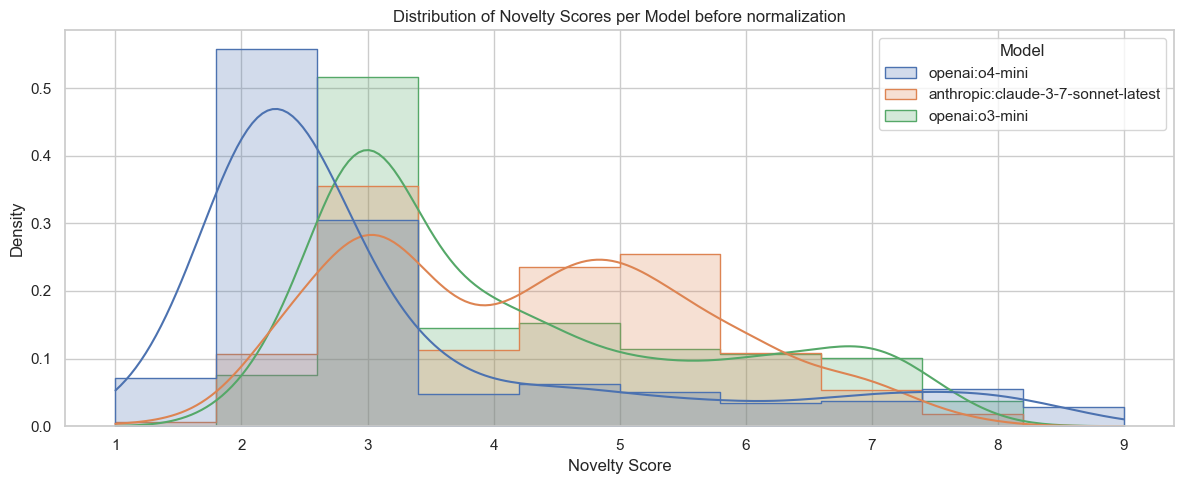

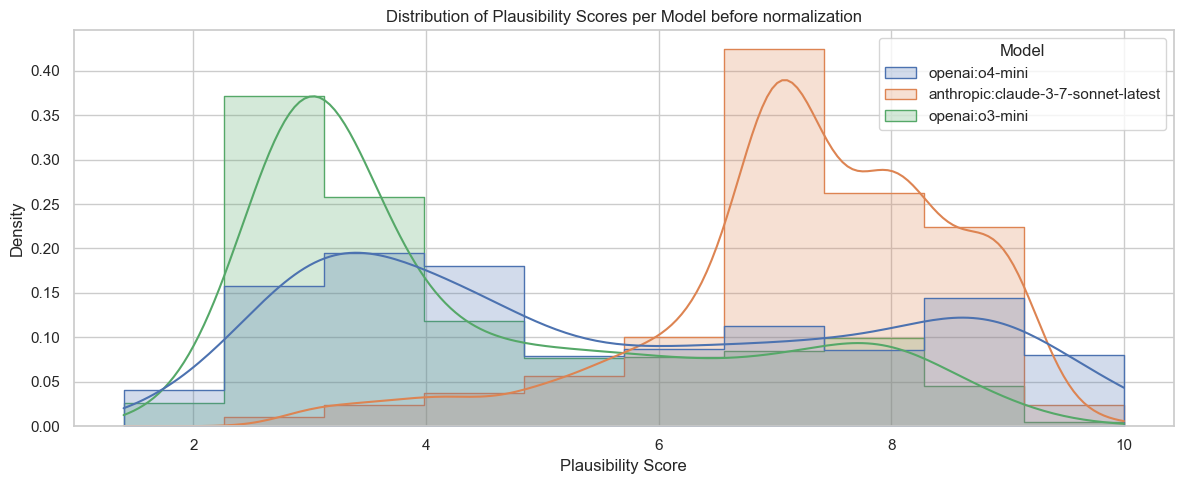

In [112]:
#distribution before normalization
# df = merged_df.copy()
df['model'] = df['model'].astype(str)

# Set plot style
sns.set(style="whitegrid")

# Novelty distribution
plt.figure(figsize=(12, 5))
plot1 = sns.histplot(data=df, x="novelty", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Novelty Scores per Model before normalization")
plt.xlabel("Novelty Score")
plt.ylabel("Density")
plot1.legend_.set_title("Model")  # Explicitly set legend title
plt.tight_layout()
plt.show()

# Plausibility distribution
plt.figure(figsize=(12, 5))
plot2 = sns.histplot(data=df, x="plausibility", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Plausibility Scores per Model before normalization")
plt.xlabel("Plausibility Score")
plt.ylabel("Density")
plot2.legend_.set_title("Model")
plt.tight_layout()
plt.show()

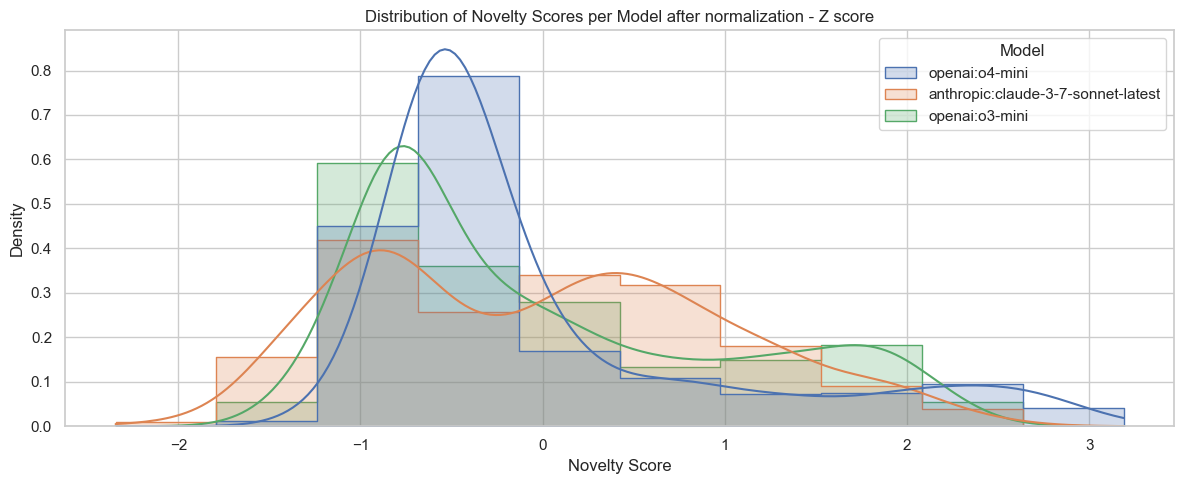

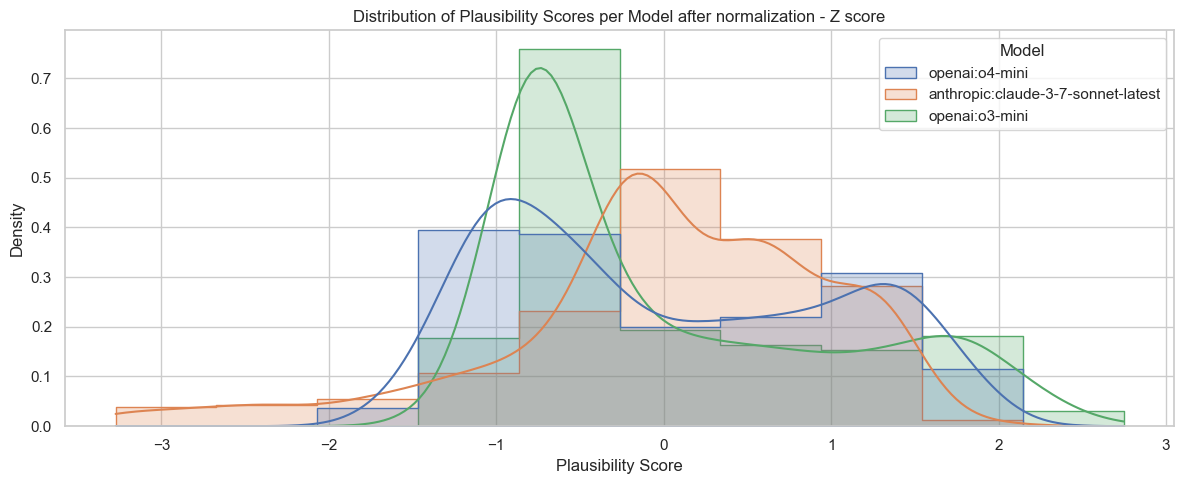

In [113]:
# Ensure 'model' is treated as a categorical variable
# df = merged_df.copy()
df['model'] = df['model'].astype(str)

# Set plot style
sns.set(style="whitegrid")

# Novelty distribution
plt.figure(figsize=(12, 5))
plot1 = sns.histplot(data=df, x="novelty_norm", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Novelty Scores per Model after normalization - Z score")
plt.xlabel("Novelty Score")
plt.ylabel("Density")
plot1.legend_.set_title("Model")  # Explicitly set legend title
plt.tight_layout()
plt.show()

# Plausibility distribution
plt.figure(figsize=(12, 5))
plot2 = sns.histplot(data=df, x="plausibility_norm", hue="model", kde=True, bins=10, element="step", stat="density", common_norm=False)
plt.title("Distribution of Plausibility Scores per Model after normalization - Z score")
plt.xlabel("Plausibility Score")
plt.ylabel("Density")
plot2.legend_.set_title("Model")
plt.tight_layout()
plt.show()

In [217]:
# Calculate the 90th percentile thresholds
novelty_thresh = df['novelty_norm'].quantile(0.708)
plausibility_thresh = df['plausibility_norm'].quantile(0.708)

# Filter rows that exceed both thresholds
data = df[(df['novelty_norm'] >= novelty_thresh) & (df['plausibility_norm'] >= plausibility_thresh)]
data

,hypothesis_id,model,novelty,plausibility,timestamp,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,...,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm
782,LGBM.GASTRIC_CANCER.261,openai:o4-mini,8,7,2025-05-05T19:08:40.943703,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,261,2.366425,0.571540
1949,LIFT.GALLBLADDER_CARCINOMA.17,openai:o4-mini,8,7,2025-05-05T21:01:10.461969,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 5 ...,NaN,NaN,TERT,...,NaN,9.2,LIFT,1426.0,upstream_gene_variant,NaN,Substitution/Indel,17,2.366425,0.571540
411,LGBM.COLORECTAL_CARCINOMA.138,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T18:31:22.060548,Colorectal Carcinoma,TMB (nonsynonymous) value is 8.766666667 AND D...,NaN,NaN,NaN,...,NaN,12.0,LGBM,NaN,NaN,NaN,NaN,138,1.658181,0.508440
633,LGBM.NON_SMALL_CELL_LUNG_CANCER.212,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T18:52:50.323070,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is LIN28A AND Smoke St...,NaN,NaN,NaN,...,NaN,9.0,LGBM,NaN,NaN,NaN,NaN,212,1.658181,0.508440
780,LGBM.GASTRIC_CANCER.261,anthropic:claude-3-7-sonnet-latest,7,8,2025-05-05T19:08:24.659823,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,261,1.658181,0.508440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,LGBM.COLORECTAL_CARCINOMA.250,openai:o4-mini,5,7,2025-05-05T19:05:12.489135,Colorectal Carcinoma,Hugo Symbol value is FAT4 AND TMB (nonsynonymo...,NaN,NaN,FAT4,...,NaN,7.0,LGBM,NaN,NaN,NaN,NaN,250,0.880423,0.571540
2387,XGBS.NON_SMALL_CELL_LUNG_CANCER.123,openai:o4-mini,5,7,2025-05-05T21:39:24.835308,Non Small Cell Lung Cancer,Chromosome value is 7 AND Exon Number value is...,NaN,NaN,NaN,...,NaN,12.0,XGBS,NaN,NaN,NaN,NaN,123,0.880423,0.571540
2627,XGBS.BREAST_CARCINOMA.203,openai:o4-mini,5,7,2025-05-05T22:00:24.935266,Breast Carcinoma,Sex value is Female AND Site1 Hugo Symbol valu...,NaN,NaN,NaN,...,NaN,7.0,XGBS,NaN,NaN,NaN,NaN,203,0.880423,0.571540
2923,XGBS.COLORECTAL_CARCINOMA.302,openai:o3-mini,5,7,2025-05-05T22:27:53.124909,Colorectal Carcinoma,Codons value is Cga/Tga AND Hugo Symbol value ...,Cga/Tga,NaN,APC,...,NaN,5.0,XGBS,NaN,NaN,NaN,NaN,302,0.466248,1.223495


In [225]:
data = df[(df["novelty_norm"] > 1) & (df["plausibility_norm"] > 0.5)]
data = data.drop(columns=['timestamp', 'novelty_norm', 'plausibility_norm', 'Unnamed: 0', 'rank'])
data['novelty'] = None
data['plausibility'] = None
data

,hypothesis_id,model,novelty,plausibility,cancer_type,hypo_factors,Codons,Start_Position,Hugo_Symbol,End_Position,...,Smoke Status,Site2_Hugo_Symbol,Protein_position,Variant_Type,splice_acceptor_variant,support,method,Consequence,Position,VAR_TYPE_SX
782,LGBM.GASTRIC_CANCER.261,openai:o4-mini,None,None,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,NaN,...,NaN,NTRK3,NaN,NaN,NaN,7.0,LGBM,NaN,NaN,NaN
1949,LIFT.GALLBLADDER_CARCINOMA.17,openai:o4-mini,None,None,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 5 ...,NaN,NaN,TERT,NaN,...,NaN,NaN,NaN,NaN,NaN,9.2,LIFT,upstream_gene_variant,NaN,Substitution/Indel
411,LGBM.COLORECTAL_CARCINOMA.138,anthropic:claude-3-7-sonnet-latest,None,None,Colorectal Carcinoma,TMB (nonsynonymous) value is 8.766666667 AND D...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,12.0,LGBM,NaN,NaN,NaN
633,LGBM.NON_SMALL_CELL_LUNG_CANCER.212,anthropic:claude-3-7-sonnet-latest,None,None,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is LIN28A AND Smoke St...,NaN,NaN,NaN,NaN,...,Smoker,LIN28A,NaN,NaN,NaN,9.0,LGBM,NaN,NaN,NaN
780,LGBM.GASTRIC_CANCER.261,anthropic:claude-3-7-sonnet-latest,None,None,Gastric Cancer,TMB (nonsynonymous) value is 0.433333333 AND D...,NaN,NaN,NaN,NaN,...,NaN,NTRK3,NaN,NaN,NaN,7.0,LGBM,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,LGBM.BREAST_CARCINOMA.277,openai:o3-mini,None,None,Breast Carcinoma,TMB (nonsynonymous) value is 0.2 AND Sex value...,NaN,NaN,NaN,NaN,...,NaN,ERBB2,NaN,NaN,NaN,6.0,LGBM,NaN,NaN,NaN
1484,LGBM.COLORECTAL_CARCINOMA.495,openai:o4-mini,None,None,Colorectal Carcinoma,Hugo Symbol value is FAT4 AND TMB (nonsynonymo...,NaN,NaN,FAT4,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,LGBM,NaN,NaN,NaN
1822,LGBM.NON_SMALL_CELL_LUNG_CANCER.608,openai:o3-mini,None,None,Non Small Cell Lung Cancer,Diagnosis Age value is 61-70 AND Site2 Hugo Sy...,NaN,NaN,NaN,NaN,...,Smoker,NEK11,NaN,NaN,NaN,3.0,LGBM,NaN,NaN,NaN
3245,XGBS.LIVER_HEPATOCELLULAR_CARCINOMA.409,openai:o4-mini,None,None,Liver Hepatocellular Carcinoma,Sex value is Male AND Site1 Hugo Symbol value ...,NaN,NaN,NaN,NaN,...,NaN,TERT,NaN,NaN,NaN,4.0,XGBS,NaN,NaN,NaN


In [226]:
data.to_excel("llm_results/normalized_new_results.xlsx", index=False)

In [114]:
# df_michal = pd.read_excel("llm_results/michal_input.xlsx")
df_michal = df.copy()

In [115]:
df_michal.columns
# computing Z score
# df_michal[['novelty_norm_michal', 'plausibility_norm_michal']] = df_michal[['novelty', 'plausibility']].transform(
#     lambda x: (x - x.mean()) / x.std()
# )
# df_michal

Index(['hypothesis_id', 'model', 'novelty', 'plausibility', 'std_novelty',
       'std_plausibility', 'cancer_type', 'hypo_factors', 'Codons',
       'Start_Position', 'Hugo_Symbol', 'End_Position',
       'upstream_gene_variant', 'TMB (nonsynonymous)', 'Sex', 'Event_Info',
       'Site1_Hugo_Symbol', 'missense_variant', 'SNP_event', 'Diagnosis Age',
       'Chromosome', 'Exon_Number', 'Smoke Status', 'Site2_Hugo_Symbol',
       'Protein_position', 'Variant_Type', 'splice_acceptor_variant',
       'support', 'method', 'Unnamed: 0', 'Consequence', 'Position',
       'VAR_TYPE_SX', 'rank', 'novelty_norm', 'plausibility_norm'],
      dtype='object')

In [105]:
# df = df[["hypothesis_id", "model", "novelty_norm", "plausibility_norm"]]
# df_michal = df_michal[["hypothesis_id", "hypo_factors", "cancer_type", "novelty_norm_michal", "plausibility_norm_michal"]]
# df_combined = (pd.merge(df, df_michal, on='hypothesis_id', how='inner'))

In [106]:
# # Calculate correlation
# correlation = df_combined['novelty_norm'].corr(df_combined['novelty_norm_michal'])
# print(f"Correlation: {correlation:.2f}")
#
# # Calculate MAE
# mae = mean_absolute_error(df_combined['novelty_norm'], df_combined['novelty_norm_michal'])
# print(f"Mean Absolute Error: {mae:.2f}")


In [116]:
full_data = pd.read_csv("narrowed_cancers_data.csv")
full_data.columns
# full_data = full_data.drop('_tmpkey', axis=1)

Index(['PATIENT_ID', 'Cancer Type', 'Cancer Type Detailed', 'Tumor Stage',
       'Sample Type', 'Sex', 'Diagnosis Age', 'Smoke Status',
       'TMB (nonsynonymous)', 'Hugo_Symbol', 'Chromosome', 'Start_Position',
       'End_Position', 'Variant_Type', 'SNP_event', 'Protein_position',
       'Codons', 'Exon_Number', 'VAR_TYPE_SX', 'Site1_Hugo_Symbol',
       'Site2_Hugo_Symbol', 'Event_Info', '3_prime_UTR_variant',
       '5_prime_UTR_variant', 'NMD_transcript_variant',
       'coding_sequence_variant', 'downstream_gene_variant',
       'frameshift_variant', 'inframe_deletion', 'inframe_insertion',
       'intergenic_variant', 'intron_variant', 'mature_miRNA_variant',
       'missense_variant', 'non_coding_transcript_exon_variant',
       'non_coding_transcript_variant', 'protein_altering_variant',
       'splice_acceptor_variant', 'splice_donor_variant',
       'splice_region_variant', 'start_lost', 'start_retained_variant',
       'stop_gained', 'stop_lost', 'stop_retained_variant',


In [117]:
# Mapping from df_michal to full_data column names
rename_dict = {
    'cancer_type': 'Cancer Type',
    'Diagnosis Age': 'Diagnosis Age',
    'Smoke Status': 'Smoke Status',
    'TMB (nonsynonymous)': 'TMB (nonsynonymous)',
    'Hugo_Symbol': 'Hugo_Symbol',
    'Chromosome': 'Chromosome',
    'Start_Position': 'Start_Position',
    'End_Position': 'End_Position',
    'Variant_Type': 'Variant_Type',
    'SNP_event': 'SNP_event',
    'Protein_position': 'Protein_position',
    'Codons': 'Codons',
    'Exon_Number': 'Exon_Number',
    'VAR_TYPE_SX': 'VAR_TYPE_SX',
    'Site1_Hugo_Symbol': 'Site1_Hugo_Symbol',
    'Site2_Hugo_Symbol': 'Site2_Hugo_Symbol',
    'Event_Info': 'Event_Info',
    'missense_variant': 'missense_variant',
    'Sex': 'Sex',
    'splice_acceptor_variant': 'splice_acceptor_variant',
    'upstream_gene_variant': 'upstream_gene_variant'
    # Add more mappings if needed
}

# Rename columns in df_michal
df_michal = df.copy()
df_michal_renamed = df_michal.rename(columns=rename_dict)
df_michal_renamed

,hypothesis_id,model,novelty,plausibility,std_novelty,std_plausibility,Cancer Type,hypo_factors,Codons,Start_Position,...,splice_acceptor_variant,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm
15025,XGBS.SOFT_TISSUE_SARCOMA.455,openai:o4-mini,9.0,2.0,0.707107,0.000000,Soft Tissue Sarcoma,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,NaN,NaN,...,NaN,4.00,XGBS,NaN,NaN,NaN,NaN,455,3.189211,-1.509796
16640,LGBM.NON_SMALL_CELL_LUNG_CANCER.371,openai:o4-mini,7.4,4.4,1.140175,1.140175,Non Small Cell Lung Cancer,Site2 Hugo Symbol value is NEK11 AND Smoke Sta...,NaN,NaN,...,NaN,5.00,LGBM,NaN,NaN,NaN,NaN,371,2.303790,-0.485365
2763,XGBS.COLORECTAL_CARCINOMA.250,openai:o4-mini,8.4,5.4,0.547723,0.894427,Colorectal Carcinoma,TMB (nonsynonymous) value is 2.333333333 AND E...,NaN,NaN,...,NaN,6.00,XGBS,NaN,NaN,NaN,NaN,250,2.857178,-0.058518
15207,XGBS.GASTRIC_CANCER.513,openai:o4-mini,8.0,5.6,0.707107,0.894427,Gastric Cancer,TMB (nonsynonymous) value is 0.233333333 AND E...,NaN,NaN,...,NaN,3.00,XGBS,NaN,NaN,NaN,NaN,513,2.635823,0.026851
18044,XGBS.NON_SMALL_CELL_LUNG_CANCER.166,openai:o4-mini,8.4,4.2,0.894427,1.095445,Non Small Cell Lung Cancer,Event Info value is NOTCH2-LIN28A AND Smoke St...,NaN,NaN,...,NaN,10.00,XGBS,NaN,NaN,NaN,NaN,166,2.857178,-0.570734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15776,LGBM.NON_SMALL_CELL_LUNG_CANCER.83,openai:o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Diagnosis Age value is 51-60 AND Sex value is ...,NaN,NaN,...,NaN,19.00,LGBM,NaN,NaN,NaN,NaN,83,-1.237897,1.819606
17513,LIFT.NON_SMALL_CELL_LUNG_CANCER.29,openai:o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Sex value is Female AND Chromosome value is 7 ...,cTg/cGg,NaN,...,NaN,3.13,LIFT,2403.0,missense_variant,55259515.0-55259515.0,Substitution/Indel,29,-1.237897,1.904975
18560,XGBS.NON_SMALL_CELL_LUNG_CANCER.338,openai:o4-mini,1.0,10.0,0.000000,0.000000,Non Small Cell Lung Cancer,Sex value is Female AND Diagnosis Age value is...,NaN,NaN,...,NaN,5.00,XGBS,NaN,NaN,NaN,NaN,338,-1.237897,1.904975
19187,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,openai:o4-mini,1.0,9.8,0.000000,0.447214,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,...,NaN,3.00,XGBS,NaN,NaN,NaN,NaN,547,-1.237897,1.819606


In [118]:

# Identify common columns
common_cols = list(set(df_michal_renamed.columns) & set(full_data.columns))
print(f"Common columns: {common_cols}")

matched_rows = []

for _, small_row in df_michal_renamed.iterrows():
    mask = np.ones(len(full_data), dtype=bool)

    for col in common_cols:
        val = small_row[col]
        mask &= (
            (full_data[col] == val) |
            pd.isna(val)
        ) & (~(pd.notna(val) & full_data[col].isna()))

    filtered = full_data[mask].copy()

    # Add all columns from df_michal_renamed (repeating for each match)
    for col in df_michal_renamed.columns:
        filtered[col] = small_row[col]

    matched_rows.append(filtered)

# Combine results
result = pd.concat(matched_rows, ignore_index=True) if matched_rows else pd.DataFrame()



Common columns: ['Smoke Status', 'upstream_gene_variant', 'splice_acceptor_variant', 'SNP_event', 'Diagnosis Age', 'End_Position', 'Codons', 'Protein_position', 'Variant_Type', 'Chromosome', 'Start_Position', 'Site2_Hugo_Symbol', 'VAR_TYPE_SX', 'Site1_Hugo_Symbol', 'missense_variant', 'Exon_Number', 'Sex', 'Cancer Type', 'TMB (nonsynonymous)', 'Event_Info', 'Hugo_Symbol']


In [124]:
result.drop_duplicates(inplace=True)
result
# result.drop_duplicates(inplace=True)
# counts = result.groupby('hypothesis_id')['PATIENT_ID'].nunique()
# counts

,PATIENT_ID,Cancer Type,Cancer Type Detailed,Tumor Stage,Sample Type,Sex,Diagnosis Age,Smoke Status,TMB (nonsynonymous),Hugo_Symbol,...,std_plausibility,hypo_factors,support,method,Unnamed: 0,Consequence,Position,rank,novelty_norm,plausibility_norm
0,Patient7209,Soft Tissue Sarcoma,Gastrointestinal Stromal Tumor,Unknown,Primary,NaN,41-50,NaN,NaN,NaN,...,0.000000,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,4.0,XGBS,NaN,NaN,NaN,455,3.189211,-1.509796
4,Patient7209,Soft Tissue Sarcoma,Gastrointestinal Stromal Tumor,Unknown,Primary,NaN,41-50,NaN,NaN,NaN,...,0.000000,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,4.0,XGBS,NaN,NaN,NaN,455,3.189211,-1.509796
8,Patient7209,Soft Tissue Sarcoma,Gastrointestinal Stromal Tumor,Unknown,Primary,NaN,41-50,NaN,NaN,NaN,...,0.000000,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,4.0,XGBS,NaN,NaN,NaN,455,3.189211,-1.509796
11,Patient3518,Non Small Cell Lung Cancer,Non Small Cell Lung Cancer Other,I,Primary,NaN,NaN,Smoker,NaN,NaN,...,1.140175,Site2 Hugo Symbol value is NEK11 AND Smoke Sta...,5.0,LGBM,NaN,NaN,NaN,371,2.303790,-0.485365
12,Patient3518,Non Small Cell Lung Cancer,Non Small Cell Lung Cancer Other,I,Primary,NaN,NaN,Smoker,NaN,NaN,...,1.140175,Site2 Hugo Symbol value is NEK11 AND Smoke Sta...,5.0,LGBM,NaN,NaN,NaN,371,2.303790,-0.485365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249820,Patient8066,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,II,Primary,Male,NaN,Smoker,NaN,NaN,...,0.547723,Sex value is Male AND Chromosome value is X AN...,3.0,XGBS,NaN,NaN,NaN,580,-1.237897,1.648868
249821,Patient8258,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,IV,Primary,Male,NaN,Smoker,NaN,NaN,...,0.547723,Sex value is Male AND Chromosome value is X AN...,3.0,XGBS,NaN,NaN,NaN,580,-1.237897,1.648868
249822,Patient9139,Non Small Cell Lung Cancer,Lung Squamous Cell Carcinoma,II,Primary,Male,NaN,Smoker,NaN,NaN,...,0.547723,Sex value is Male AND Chromosome value is X AN...,3.0,XGBS,NaN,NaN,NaN,580,-1.237897,1.648868
249823,Patient9187,Non Small Cell Lung Cancer,Lung Adenocarcinoma,III,Primary,Male,NaN,Smoker,NaN,NaN,...,0.547723,Sex value is Male AND Chromosome value is X AN...,3.0,XGBS,NaN,NaN,NaN,580,-1.237897,1.648868


In [17]:
# Compute unique PATIENT_ID count per hypothesis_id
patient_counts = result.groupby('hypothesis_id')['PATIENT_ID'].nunique().reset_index()
patient_counts.rename(columns={'PATIENT_ID': 'unique_patient_count'}, inplace=True)

# Merge into df_michal_renamed
df_michal_renamed = df_michal_renamed.merge(patient_counts, on='hypothesis_id', how='left')

In [24]:
df_michal_renamed.sort_values(by=["novelty", 'unique_patient_count', "plausibility"], ascending=[False, False, False], inplace=True)
df_michal_renamed

,hypothesis_id,model,novelty,plausibility,Cancer Type,hypo_factors,Codons,Start_Position,Hugo_Symbol,End_Position,...,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm,unique_patient_count
0,XGBS.BREAST_CARCINOMA.458,openai:o4-mini,9.0,2.8,Breast Carcinoma,Sex value is Female AND Event Info value is PM...,NaN,NaN,NaN,NaN,...,3.00,XGBS,NaN,NaN,NaN,NaN,458,3.189211,-1.168319,1.0
1,XGBS.SOFT_TISSUE_SARCOMA.455,openai:o4-mini,9.0,2.0,Soft Tissue Sarcoma,Event Info value is PRKDC-KCNV1 AND Diagnosis ...,NaN,NaN,NaN,NaN,...,4.00,XGBS,NaN,NaN,NaN,NaN,455,3.189211,-1.509796,1.0
2,XGBS.NON_SMALL_CELL_LUNG_CANCER.165,openai:o4-mini,8.8,2.0,Non Small Cell Lung Cancer,Event Info value is MEN1-SBDS AND Smoke Status...,NaN,NaN,NaN,NaN,...,10.00,XGBS,NaN,NaN,NaN,NaN,165,3.078534,-1.509796,1.0
3,XGBS.NON_SMALL_CELL_LUNG_CANCER.563,openai:o4-mini,8.6,3.8,Non Small Cell Lung Cancer,Event Info value is MICAL3-PDGFB AND Smoke Sta...,NaN,NaN,NaN,NaN,...,3.00,XGBS,NaN,NaN,NaN,NaN,563,2.967856,-0.741473,1.0
4,XGBS.GASTRIC_CANCER.176,openai:o4-mini,8.6,3.0,Gastric Cancer,TMB (nonsynonymous) value is 0.333333333 AND E...,NaN,NaN,NaN,NaN,...,9.00,XGBS,NaN,NaN,NaN,NaN,176,2.967856,-1.082950,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,LGBM.NON_SMALL_CELL_LUNG_CANCER.435,openai:o4-mini,1.0,10.0,Non Small Cell Lung Cancer,Protein position value is 858.0 AND Hugo Symbo...,NaN,NaN,EGFR,NaN,...,4.00,LGBM,NaN,NaN,NaN,NaN,435,-1.237897,1.904975,82.0
3880,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,openai:o4-mini,1.0,9.8,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,EGFR,NaN,...,3.00,XGBS,NaN,NaN,NaN,NaN,547,-1.237897,1.819606,82.0
3875,LGBM.NON_SMALL_CELL_LUNG_CANCER.169,openai:o4-mini,1.0,10.0,Non Small Cell Lung Cancer,Event Info value is EML4-ALK AND Site2 Hugo Sy...,NaN,NaN,NaN,NaN,...,11.00,LGBM,NaN,NaN,NaN,NaN,169,-1.237897,1.904975,63.0
3878,XGBS.NON_SMALL_CELL_LUNG_CANCER.338,openai:o4-mini,1.0,10.0,Non Small Cell Lung Cancer,Sex value is Female AND Diagnosis Age value is...,NaN,NaN,NaN,NaN,...,5.00,XGBS,NaN,NaN,NaN,NaN,338,-1.237897,1.904975,7.0


In [34]:
dd = df_michal_renamed[df_michal_renamed["unique_patient_count"] > 3]
dd

,hypothesis_id,model,novelty,plausibility,Cancer Type,hypo_factors,Codons,Start_Position,Hugo_Symbol,End_Position,...,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm,unique_patient_count
90,XGBS.NON_SMALL_CELL_LUNG_CANCER.327,anthropic:claude-3-7-sonnet-latest,7.6,3.0,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.2 AND Chromosom...,NaN,NaN,NaN,NaN,...,5.00,XGBS,NaN,NaN,NaN,NaN,327,2.373988,-3.273152,24.0
120,LGBM.NON_SMALL_CELL_LUNG_CANCER.436,anthropic:claude-3-7-sonnet-latest,7.4,3.4,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.1 AND SNP event...,NaN,NaN,NaN,NaN,...,4.00,LGBM,NaN,NaN,NaN,NaN,436,2.231014,-2.966701,20.0
140,XGBS.COLORECTAL_CARCINOMA.481,openai:o3-mini,7.4,2.4,Colorectal Carcinoma,Codons value is Cgc/Tgc AND Sex value is Male ...,Cgc/Tgc,NaN,NaN,NaN,...,3.00,XGBS,NaN,NaN,NaN,NaN,481,2.086144,-1.063082,13.0
145,LGBM.COLORECTAL_CARCINOMA.218,openai:o4-mini,7.2,5.6,Colorectal Carcinoma,Codons value is Cga/Tga AND Hugo Symbol value ...,Cga/Tga,NaN,AMER1,NaN,...,8.00,LGBM,NaN,NaN,NaN,NaN,218,2.193112,0.026851,47.0
157,LIFT.GALLBLADDER_CARCINOMA.12,openai:o3-mini,7.2,3.6,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 12...,NaN,NaN,ARID2,NaN,...,12.42,LIFT,1428.0,NaN,NaN,Truncation,12,1.956530,-0.445331,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,LGBM.COLORECTAL_CARCINOMA.320,openai:o4-mini,1.0,10.0,Colorectal Carcinoma,Protein position value is 12.0 AND Codons valu...,gGt/gTt,NaN,KRAS,NaN,...,5.00,LGBM,NaN,NaN,NaN,NaN,320,-1.237897,1.904975,104.0
3876,LGBM.NON_SMALL_CELL_LUNG_CANCER.435,openai:o4-mini,1.0,10.0,Non Small Cell Lung Cancer,Protein position value is 858.0 AND Hugo Symbo...,NaN,NaN,EGFR,NaN,...,4.00,LGBM,NaN,NaN,NaN,NaN,435,-1.237897,1.904975,82.0
3880,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,openai:o4-mini,1.0,9.8,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,EGFR,NaN,...,3.00,XGBS,NaN,NaN,NaN,NaN,547,-1.237897,1.819606,82.0
3875,LGBM.NON_SMALL_CELL_LUNG_CANCER.169,openai:o4-mini,1.0,10.0,Non Small Cell Lung Cancer,Event Info value is EML4-ALK AND Site2 Hugo Sy...,NaN,NaN,NaN,NaN,...,11.00,LGBM,NaN,NaN,NaN,NaN,169,-1.237897,1.904975,63.0


In [40]:
len(list(dd["hypothesis_id"].unique()))

,hypothesis_id,model,novelty,plausibility,Cancer Type,hypo_factors,Codons,Start_Position,Hugo_Symbol,End_Position,...,support,method,Unnamed: 0,Consequence,Position,VAR_TYPE_SX,rank,novelty_norm,plausibility_norm,unique_patient_count
90,XGBS.NON_SMALL_CELL_LUNG_CANCER.327,anthropic:claude-3-7-sonnet-latest,7.6,3.0,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.2 AND Chromosom...,NaN,NaN,NaN,NaN,...,5.00,XGBS,NaN,NaN,NaN,NaN,327,2.373988,-3.273152,24.0
120,LGBM.NON_SMALL_CELL_LUNG_CANCER.436,anthropic:claude-3-7-sonnet-latest,7.4,3.4,Non Small Cell Lung Cancer,TMB (nonsynonymous) value is 0.1 AND SNP event...,NaN,NaN,NaN,NaN,...,4.00,LGBM,NaN,NaN,NaN,NaN,436,2.231014,-2.966701,20.0
140,XGBS.COLORECTAL_CARCINOMA.481,openai:o3-mini,7.4,2.4,Colorectal Carcinoma,Codons value is Cgc/Tgc AND Sex value is Male ...,Cgc/Tgc,NaN,NaN,NaN,...,3.00,XGBS,NaN,NaN,NaN,NaN,481,2.086144,-1.063082,13.0
145,LGBM.COLORECTAL_CARCINOMA.218,openai:o4-mini,7.2,5.6,Colorectal Carcinoma,Codons value is Cga/Tga AND Hugo Symbol value ...,Cga/Tga,NaN,AMER1,NaN,...,8.00,LGBM,NaN,NaN,NaN,NaN,218,2.193112,0.026851,47.0
157,LIFT.GALLBLADDER_CARCINOMA.12,openai:o3-mini,7.2,3.6,Gallbladder Carcinoma,Sex value is Female AND Chromosome value is 12...,NaN,NaN,ARID2,NaN,...,12.42,LIFT,1428.0,NaN,NaN,Truncation,12,1.956530,-0.445331,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,LGBM.COLORECTAL_CARCINOMA.320,openai:o4-mini,1.0,10.0,Colorectal Carcinoma,Protein position value is 12.0 AND Codons valu...,gGt/gTt,NaN,KRAS,NaN,...,5.00,LGBM,NaN,NaN,NaN,NaN,320,-1.237897,1.904975,104.0
3876,LGBM.NON_SMALL_CELL_LUNG_CANCER.435,openai:o4-mini,1.0,10.0,Non Small Cell Lung Cancer,Protein position value is 858.0 AND Hugo Symbo...,NaN,NaN,EGFR,NaN,...,4.00,LGBM,NaN,NaN,NaN,NaN,435,-1.237897,1.904975,82.0
3880,XGBS.NON_SMALL_CELL_LUNG_CANCER.547,openai:o4-mini,1.0,9.8,Non Small Cell Lung Cancer,Hugo Symbol value is EGFR AND TMB (nonsynonymo...,NaN,NaN,EGFR,NaN,...,3.00,XGBS,NaN,NaN,NaN,NaN,547,-1.237897,1.819606,82.0
3875,LGBM.NON_SMALL_CELL_LUNG_CANCER.169,openai:o4-mini,1.0,10.0,Non Small Cell Lung Cancer,Event Info value is EML4-ALK AND Site2 Hugo Sy...,NaN,NaN,NaN,NaN,...,11.00,LGBM,NaN,NaN,NaN,NaN,169,-1.237897,1.904975,63.0


In [20]:
data = dd[(dd["novelty_norm"] > 0.9) & (dd["plausibility_norm"] > -0.3)]
data = data.drop(columns=['novelty_norm', 'plausibility_norm', 'Unnamed: 0', 'rank'])
# data['novelty'] = None
# data['plausibility'] = None
data

NameError: name 'dd' is not defined

In [19]:
data.join(df_michal, on='hypothesis_id')

NameError: name 'data' is not defined